# Проект для «Викишоп» с BERT

**Описание задачи**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## 1. Загрузка данных

Для начала загрузим и импортируем необходимые для дальнейшей работы библиотеки.

In [1]:
!pip install catboost

In [30]:
!pip install detoxify

In [63]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from catboost import CatBoostClassifier
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords as nltk_stopwords
from scipy import sparse
import time
from detoxify import Detoxify

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\y.a.levina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\y.a.levina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\y.a.levina\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Данные с комментариями и метками токсичности находятся в файле `toxic_comments.csv`, загрузим его содержимое.

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


Мы сразу видим лишнюю колонку `Unnamed: 0`, не несущую в себе никакой информации, избавимся от нее.

In [4]:
df = df[['text', 'toxic']]
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


Посмотрим дополнительную информацию о датафрейме.

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [86]:
df['toxic'].unique()

array([0, 1], dtype=int64)

Итак, в нашем распоряжении находится датафрейм, содержащий строковые данные в колонке `text`, которую мы будем использовать в качестве признака для обучения, а также колонка `toxic` с цифрами `0` и `1` - целевой признак, отражающий токсичность комментария (0 - не токсичный, 1 - токсичный).

## 2. Подготовка данных

Для начала нем необходимо разделить имеющийся датасет на датасеты для обучения, валидации и тестировать. Это необходимо для того, чтобы предварительная обработка текста для валидационной и тестовой выборок была независима (моделирование тестирования на "незнакомых" данных для модели).

In [5]:
train, val_test = train_test_split(df, test_size=0.1, random_state=42)
val, test = train_test_split(val_test, test_size=0.5, random_state=42)

In [6]:
val

,text,toxic
153838,Is Sagbliss a bigamist ?????,0
51445,One last thing... \n\nYou are a thundercunt of...,0
31684,"Hello, I think you are a fuckwad. Eat shit and...",1
97256,"OK, I've made another slew of blocks after con...",0
73261,Lunar Eclipse?? \n\nThese happen at least 2 ti...,0
...,...,...
39590,"I swear to God, I will leave everything on Wik...",0
152255,Churchill \n\nThat's not true. It is as much ...,0
29975,"""\n\nWhat are you talking about?\n\nRegarding ...",0
38434,"""\nThank you kindly, . Whatever you did, the ...",0


- Очистка

Уже при выводе нескольких частей текста можно заметить присутствие лишних символов, не несущих никакой информации и лишь создающих шум для модели. Очистим тесты от них. Для этого напишем отдельную функцию.

In [7]:
def clear_text(text):
    t = re.sub(r'[^a-zA-Z ]', ' ', text)
    lemm_list = t.split()
    text_ret = " ".join(lemm_list)

    return text_ret

Далее проведем непосредственно очистку для тренировочной и валидационной выборок. Для тестовой выборки вся необходимая предобработка будет происходить на этапе тестирования выбранной по лучшей метрике `F1` модели.

In [8]:
train['text_re'] = train['text'].apply(clear_text)
val['text_re'] = val['text'].apply(clear_text)
train

,text,toxic,text_re
74250,Stop Deleting Images Without First Consulting ...,0,Stop Deleting Images Without First Consulting ...
101310,Controversial material of any kind that is uns...,0,Controversial material of any kind that is uns...
147342,"Image source info \n\nHi there, as I was clear...",0,Image source info Hi there as I was clearing o...
90758,"Extra stuff to go, reduce article size\nThis i...",0,Extra stuff to go reduce article size This is ...
127220,Lol! It would look silly if he didnt grow at a...,0,Lol It would look silly if he didnt grow at al...
...,...,...,...
119879,"""\n First of all, editor TheRedPenOfDoom is no...",0,First of all editor TheRedPenOfDoom is not a M...
103694,and decided to become gay,1,and decided to become gay
131932,John Bull vs. Adolf Hitler \n\n \nLook at the ...,0,John Bull vs Adolf Hitler Look at the pictures...
146867,October 2009 \n\nYou have a lot to learn about...,0,October You have a lot to learn about the way ...


- Лемматизация

Далее проведем лемматизацию, т.е. приведение слов в тексте к их лемме (их нормальной словарной форме). Для этого воспользуемся `WordNetLemmatizer()`. Также, поскольку процесс необходимо будет выполнить для всех выборок, поместим его в функцию.

In [9]:
lemmatizer = WordNetLemmatizer()

In [10]:
def lemmatize_text(text):
    lemm = lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
    return lemm(text)

Теперь применяем лемматизатор на базе ранее очищенного теста.

In [11]:
train['lemmatized_text'] = train['text_re'].apply(lemmatize_text)
val['lemmatized_text'] = val['text_re'].apply(lemmatize_text)
train

,text,toxic,text_re,lemmatized_text
74250,Stop Deleting Images Without First Consulting ...,0,Stop Deleting Images Without First Consulting ...,Stop Deleting Images Without First Consulting ...
101310,Controversial material of any kind that is uns...,0,Controversial material of any kind that is uns...,Controversial material of any kind that is uns...
147342,"Image source info \n\nHi there, as I was clear...",0,Image source info Hi there as I was clearing o...,Image source info Hi there a I wa clearing out...
90758,"Extra stuff to go, reduce article size\nThis i...",0,Extra stuff to go reduce article size This is ...,Extra stuff to go reduce article size This is ...
127220,Lol! It would look silly if he didnt grow at a...,0,Lol It would look silly if he didnt grow at al...,Lol It would look silly if he didnt grow at al...
...,...,...,...,...
119879,"""\n First of all, editor TheRedPenOfDoom is no...",0,First of all editor TheRedPenOfDoom is not a M...,First of all editor TheRedPenOfDoom is not a M...
103694,and decided to become gay,1,and decided to become gay,and decided to become gay
131932,John Bull vs. Adolf Hitler \n\n \nLook at the ...,0,John Bull vs Adolf Hitler Look at the pictures...,John Bull v Adolf Hitler Look at the picture o...
146867,October 2009 \n\nYou have a lot to learn about...,0,October You have a lot to learn about the way ...,October You have a lot to learn about the way ...


- Стоп-слова и TF-IDF

Далее мы обучим несколько моделей: `Логистическая регрессия`, `CatBoost` и `Detoxify` на базе `BERT`. Для двух последних тесты не обязательно переводить в матрицу TF-IDF, у них есть собственные встроенные методы. Модель Логистическая регрессия таких не имеет, поэтому создадим для нее отдельные признаки с помощью TF-IDF.

In [12]:
stopwords = set(nltk_stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=list(stopwords),lowercase=True)

In [14]:
# Преобразование колонки 'lemmatized_text' в матрицу TF-IDF
tfidf_matrix_train = vectorizer.fit_transform(train['lemmatized_text'])
tfidf_matrix_sparse_train = sparse.csr_matrix(tfidf_matrix_train) # Преобразование в разреженную матрицу формата CSR

# Создание разреженного датафрейма из разреженной матрицы TF-IDF
df_tfidf_train = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix_sparse_train, columns=vectorizer.get_feature_names_out())

tfidf_matrix_val = vectorizer.transform(val['lemmatized_text'])
tfidf_matrix_sparse_val = sparse.csr_matrix(tfidf_matrix_val) # Преобразование в разреженную матрицу формата CSR

# Создание разреженного датафрейма из разреженной матрицы TF-IDF
df_tfidf_val = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix_sparse_val, columns=vectorizer.get_feature_names_out())

# Вывод датафрейма с разреженной матрицей TF-IDF
df_tfidf_train

,aa,aaa,aaaa,aaaaa,aaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany,aaaaaaaaaah,aaaaaaaaadm,aaaaaaaaaq,aaaaaaaacfo,...,zzz,zzzz,zzzzz,zzzzzzz,zzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Обучение моделей

Для эксперимента мы выбрали 3 максимально разнообразные модели:
- `Логистическая регрессия`: базовая модель, для которой мы также применили преобразование текста в матрицу TF-IDF.
- `CatBoostClassifier`: модель гадиентного бустинга, преобразования текста не требует, т.к. имеет собственные методы TF-IDF.
- `Detoxify` на базе `BERT`: является предобученной моделью, разработаной на базе нейронной сети для работы с текстами BERT.

- **Логистическая регрессия**

Для `Логистической регрессии` мы ранее провели генерацию тектов тренировочной и тестовой выборок с помощью TF-IDF и получили `df_tfidf_train` и `df_tfidf_val`, объявим из них итоговые данные для тестирования и валидации.

In [ ]:
X_train = df_tfidf_train
y_train = train['toxic']

X_val = df_tfidf_val
y_val = val['toxic']

Теперь можно создать и обучить модель на тестовой выборке. Также замерим время обучения.

In [17]:
start_time = time.time()

# Создание и обучение модели логистической регрессии
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

execution_time = time.time() - start_time
print("Время выполнения:", round(execution_time,2), "сек")

Время выполнения: 14.36 сек


Обучение модели длилось всего 14 секунд, что показывает очень высокую скорость для такого объема данных. Предскажем и добавим в валидационный датасет вероятности отнесения текста к токсичному с помощью `predict_proba`.

In [18]:
val['y_pred'] = model.predict_proba(X_val)[:,1]
val

,text,toxic,text_re,lemmatized_text,y_pred
153838,Is Sagbliss a bigamist ?????,0,Is Sagbliss a bigamist,Is Sagbliss a bigamist,0.076587
51445,One last thing... \n\nYou are a thundercunt of...,0,One last thing You are a thundercunt of Piers ...,One last thing You are a thundercunt of Piers ...,0.064129
31684,"Hello, I think you are a fuckwad. Eat shit and...",1,Hello I think you are a fuckwad Eat shit and die,Hello I think you are a fuckwad Eat shit and die,0.994387
97256,"OK, I've made another slew of blocks after con...",0,OK I ve made another slew of blocks after conf...,OK I ve made another slew of block after confi...,0.039741
73261,Lunar Eclipse?? \n\nThese happen at least 2 ti...,0,Lunar Eclipse These happen at least times each...,Lunar Eclipse These happen at least time each ...,0.043955
...,...,...,...,...,...
39590,"I swear to God, I will leave everything on Wik...",0,I swear to God I will leave everything on Wiki...,I swear to God I will leave everything on Wiki...,0.154488
152255,Churchill \n\nThat's not true. It is as much ...,0,Churchill That s not true It is as much of a P...,Churchill That s not true It is a much of a PO...,0.070377
29975,"""\n\nWhat are you talking about?\n\nRegarding ...",0,What are you talking about Regarding this edit...,What are you talking about Regarding this edit...,0.011154
38434,"""\nThank you kindly, . Whatever you did, the ...",0,Thank you kindly Whatever you did the emoji da...,Thank you kindly Whatever you did the emoji da...,0.033587


Для более точного предсказания подберем порог для максимальной метрики `F1`. Для  этого создадим список порогов от `0` до `1` с шагом `0.01`, воспользовавшись библиотекой `numpy`.

In [19]:
np.linspace(0,1,101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

Теперь сформируем список порогов и метрики `F1` на базе предсказаний на валидационной выборке в колонке `y_pred` и выведем на экран график метрики в зависимости от порога.

100%|██████████| 101/101 [00:00<00:00, 294.18it/s]


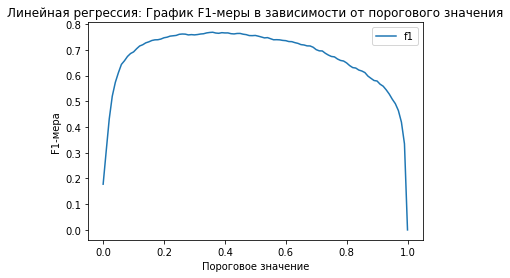

In [66]:
rez = []

for thr in tqdm(np.linspace(0,1,101)):
    rez.append((thr, f1_score(y_val, val['y_pred']>thr)))
    
df_f1 = pd.DataFrame(rez, columns=['thr', 'f1'])
df_f1.set_index('thr').plot()
plt.title("Линейная регрессия: График F1-меры в зависимости от порогового значения")
plt.xlabel("Пороговое значение")
plt.ylabel("F1-мера")
plt.show()

Согласно графику мы видим, что `F1` достигает своего максимума  в районе порогов `0.2-0.3`, далее она планомерно идет на убыль. Отсортируем значения по убыванию метрики и посмотрим порог с наибольшей `F1`.

In [22]:
df_f1.sort_values('f1', ascending=False)

,thr,f1
29,0.29,0.786594
28,0.28,0.786441
25,0.25,0.785904
26,0.26,0.785571
27,0.27,0.784367
...,...,...
99,0.99,0.314534
2,0.02,0.292211
1,0.01,0.230415
0,0.00,0.177763


У модели `Линейная регрессия` наилучший показатель `F1` составляет `0.79` и достигается при пороге в `0.29`.

- **CatBoost**

CatBoostClassifier имеет собственные методы TF-IDF, поэтому предварительного преобразования текста не требует. Укажем для модели колонку `lemmatized_text` с очищенным и лемматизированным текстом как признак и как текстовую колонку для указании в модели далее, а также целевой признак `toxic`.

In [23]:
X = ['lemmatized_text']
text_features = ['lemmatized_text']
y = ['toxic']

Обучим нашу модель. Для этого укажем, что работаем с текстом и в какой колонке он находится через параметр `text_features`. Обучение проведем на базе оценки на валидационной выборке по метрике `ROC-AUC` и впоследствии подберем днаиболее подходящий порог.

In [85]:
params = {'eval_metric': 'AUC',
          'learning_rate': 0.04,
          'early_stopping_rounds': 100,
          'text_features': text_features,
          'verbose': 100}

model = CatBoostClassifier(**params, random_state=42)
model.fit(train[X], train[y], eval_set=(val[X], val[y]))

0:	test: 0.8619620	best: 0.8619620 (0)	total: 131ms	remaining: 2m 10s
100:	test: 0.9436342	best: 0.9436342 (100)	total: 16.5s	remaining: 2m 26s
200:	test: 0.9511563	best: 0.9511563 (200)	total: 35.2s	remaining: 2m 20s
300:	test: 0.9554187	best: 0.9554187 (300)	total: 53.8s	remaining: 2m 5s
400:	test: 0.9580403	best: 0.9580403 (400)	total: 1m 14s	remaining: 1m 50s
500:	test: 0.9594240	best: 0.9594240 (500)	total: 1m 33s	remaining: 1m 32s
600:	test: 0.9603446	best: 0.9603446 (599)	total: 1m 53s	remaining: 1m 15s
700:	test: 0.9612373	best: 0.9612373 (700)	total: 2m 14s	remaining: 57.4s
800:	test: 0.9616426	best: 0.9616480 (799)	total: 2m 36s	remaining: 38.8s
900:	test: 0.9620188	best: 0.9620353 (894)	total: 2m 55s	remaining: 19.2s
999:	test: 0.9622156	best: 0.9622490 (984)	total: 3m 13s	remaining: 0us

bestTest = 0.9622490365
bestIteration = 984

Shrink model to first 985 iterations.


In [87]:
val['y_pred'] = model.predict_proba(val[X])[:,1]
val

,text,toxic,text_re,lemmatized_text,y_pred,detox_y_score
153838,Is Sagbliss a bigamist ?????,0,Is Sagbliss a bigamist,Is Sagbliss a bigamist,0.068443,0.063645
51445,One last thing... \n\nYou are a thundercunt of...,0,One last thing You are a thundercunt of Piers ...,One last thing You are a thundercunt of Piers ...,0.112893,0.097799
31684,"Hello, I think you are a fuckwad. Eat shit and...",1,Hello I think you are a fuckwad Eat shit and die,Hello I think you are a fuckwad Eat shit and die,0.995054,0.996711
97256,"OK, I've made another slew of blocks after con...",0,OK I ve made another slew of blocks after conf...,OK I ve made another slew of block after confi...,0.013550,0.022620
73261,Lunar Eclipse?? \n\nThese happen at least 2 ti...,0,Lunar Eclipse These happen at least times each...,Lunar Eclipse These happen at least time each ...,0.008050,0.000601
...,...,...,...,...,...,...
39590,"I swear to God, I will leave everything on Wik...",0,I swear to God I will leave everything on Wiki...,I swear to God I will leave everything on Wiki...,0.033134,0.003192
152255,Churchill \n\nThat's not true. It is as much ...,0,Churchill That s not true It is as much of a P...,Churchill That s not true It is a much of a PO...,0.016740,0.009442
29975,"""\n\nWhat are you talking about?\n\nRegarding ...",0,What are you talking about Regarding this edit...,What are you talking about Regarding this edit...,0.021920,0.000839
38434,"""\nThank you kindly, . Whatever you did, the ...",0,Thank you kindly Whatever you did the emoji da...,Thank you kindly Whatever you did the emoji da...,0.005682,0.000725


Cформируем список порогов и метрики `F1` на базе предсказаний на валидационной выборке в колонке `y_pred` и выведем на экран график метрики в зависимости от порога.

100%|██████████| 101/101 [00:00<00:00, 217.74it/s]


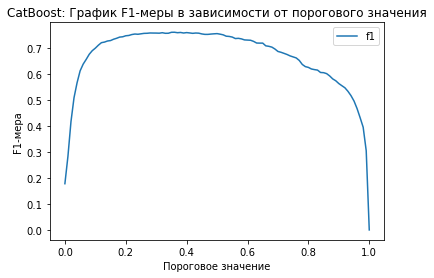

In [88]:
rez = []

for thr in tqdm(np.linspace(0,1,101)):
    rez.append((thr, f1_score(val[y], val['y_pred']>thr)))
    
df_f1 = pd.DataFrame(rez, columns=['thr', 'f1'])
df_f1.set_index('thr').plot()
plt.title("CatBoost: График F1-меры в зависимости от порогового значения")
plt.xlabel("Пороговое значение")
plt.ylabel("F1-мера")
plt.show()

Согласно графику мы видим, что `F1` достигает своего максимума  в районе порогов `0.3-0.4`, далее она идет на убыль. Отсортируем значения по убыванию метрики и посмотрим порог с наибольшей `F1`.

In [89]:
df_f1.sort_values('f1', ascending=False)

,thr,f1
36,0.36,0.760471
35,0.35,0.760234
38,0.38,0.759628
40,0.40,0.759085
37,0.37,0.758711
...,...,...
98,0.98,0.395062
99,0.99,0.304679
1,0.01,0.283183
0,0.00,0.177763


У модели `CatBoost` наилучший показатель `F1` составляет `0.76` и достигается при пороге в `0.36`.

- Detoxify на базе BERT

`Detoxify` является обученной языковой моделью на базе нейронной сети `BERT`. Данная разновидность была разработана специально для определения токсчности комментариев и находится в открытом доступе:
https://huggingface.co/unitary/toxic-bert

Поскольку модель предобученная, поведем ее валидацию с подбором наиболее подходящего порога.

In [32]:
def detox(txt):
    return Detoxify('original').predict(txt)['toxicity']

val['detox_y_score'] = val['lemmatized_text'].progress_apply(detox)

Переберем также все пороги с шагом `0.01` и определим для каждого `F1`, визуализируем результаты.

100%|██████████| 101/101 [00:00<00:00, 225.97it/s]


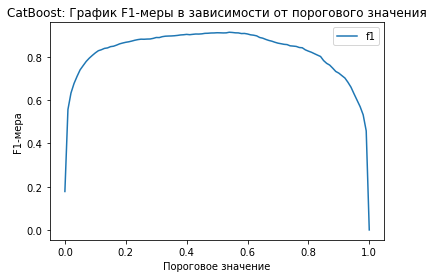

In [68]:
rez_detox = []

for thr in tqdm(np.linspace(0,1,101)):
    rez_detox.append((thr, f1_score(val[y], val['detox_y_score']>thr)))
    
df_detox = pd.DataFrame(rez_detox, columns=['thr', 'f1'])
df_detox.set_index('thr').plot()
plt.title("CatBoost: График F1-меры в зависимости от порогового значения")
plt.xlabel("Пороговое значение")
plt.ylabel("F1-мера")
plt.show()

Модель показывает достаточно высокую метрику `F1` на протяжении многих порогов. Ее максимум достигается в районе порогов `0.5-0.6`. Отсортируем значения по убыванию метрики и посмотрим порог с наибольшей `F1`.

In [54]:
df_detox.sort_values('f1', ascending=False)

,thr,f1
54,0.54,0.914658
55,0.55,0.913613
50,0.50,0.912348
51,0.51,0.912010
56,0.56,0.911958
...,...,...
1,0.01,0.557153
98,0.98,0.532578
99,0.99,0.458333
0,0.00,0.177763


Модель `Detoxify` на базе `BERT` показывает очень высокие значения метрики качества, наилучший показатель `F1` составляет `0.91` и достигается при пороге в `0.54`.

Выведем результаты обучения и валидации имеющихся моделей.

In [90]:
df_score = pd.DataFrame(
    {'Модель': ['Логистическая регрессия', 'CatBoost', 'Detoxify на базе BERT'],
     'F1 на валидационной выборке': [0.79, 0.76, 0.91]
    }
)

df_score

,Модель,F1 на валидационной выборке
0,Логистическая регрессия,0.79
1,CatBoost,0.76
2,Detoxify на базе BERT,0.91


Для наглядности также визуализируем.

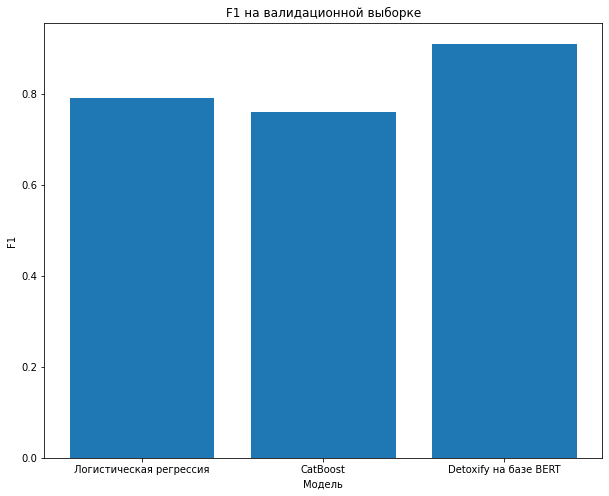

In [91]:
plt.figure(figsize=(10, 8))
plt.bar(df_score['Модель'], df_score['F1 на валидационной выборке'])
plt.xlabel('Модель')
plt.ylabel('F1')
plt.title('F1 на валидационной выборке')
plt.show()

Мы видим, что `Логистическа регрессия` и `CatBoost` дают примерно одинаковый результат. При этом языковая модель `Detoxify` на базе нейронной сети `BERT` отражает существенно более высокие результаты метрики `F1`.

Обозначим порог с максимальной метрикой на валидационной выборке и проведем далее тестирование.

In [55]:
threshold_detox = df_detox.sort_values('f1', ascending=False).iloc[0]['thr']
print("Порог при максимальном F1:", round(threshold_detox,2))

Порог при максимальном F1: 0.54


## 4. Тестирование лучшей модели

Для моделирования ситуации получния новых данных перед непосредственным тестированием проведем очистку и лемматизацию текста тестовой выборки.

In [56]:
test['text_re'] = test['text'].apply(clear_text)
test['lemmatized_text'] = test['text_re'].apply(lemmatize_text)

Предскажем вероятность классификации комментария к токсичным с помощью выбранной модели, которая была прописана ранее в процедуре `detox`.

In [58]:
test['y_score'] = test['lemmatized_text'].progress_apply(detox)

100%|██████████| 7965/7965 [5:38:07<00:00,  2.55s/it]  


С помощью установленного на валидации порога определим ответы нашей модели и рассчитаем `F1` для теста.

In [59]:
f1 = f1_score(test[y], test['y_score']>threshold_detox)
print("F1 Score на тестовой выборке:", f1)

F1 Score на тестовой выборке: 0.9117647058823529


Метрика качества `F1` при определении токсичности комментариев на тестовой выборке составила `0.91`. Это достаточно высокий показатель точности. Условие задачи по значениею `F1 не меньше 0.75` выполнено.

## 5. Выводы

В рамках данного проекта необходимо было найти модель, которая будет предсказывать токсичность комментариев с метрикой качества `F1` не менее `0.75`. В ходе решения задачи была проделана следующая работа:
1. Загружены, проанализированы и подготовлены данные с комментариями и признаком токсичности, на базе которых в дальнейшем будет проводиться обучение.
2. Проведена очистка и лемматизация текста. Для `Логистической регрессии` проведено преобразование текста в матрицу TF-IDF.
3. Обучены различные модели: `Логистическая регрессия`, `CatBoostClassifier`, а также использована предобученная языковая модель `Detoxify` на базе нейронной сети `BERT`. Для всех моделей на валидации были подобраны оптимальные для максимального `F1` пороги.
4. Выбрана лучшая по метрике качества модель `Detoxify` на базе `BERT` с показателем `F1` на валидации `0.91`.
5. Протестирована выбранная модель: метрика качества `F1` на тестовой выборке составила `0.91`. Условие задачи по значениею `F1 не меньше 0.75` выполнено.